In [1]:
from __future__ import division

import collections
import numpy as np
import matplotlib.pyplot as plt

## NN libs
import keras
from keras import backend as K
from keras import regularizers
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import TensorBoard

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.


In [2]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# local libs
import config, models, setup, compression, ncd_evaluation
import midi
import midi.decode
from midi import generators as g
from utils import io, models_io, utils, plot, string
from capsule.layers import Capsule, Length
from capsule.capsulefunctions import squash, softmax, margin_loss

In [4]:
context = setup.init(max_bars=4)

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_timestesp = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]

Setting up params

max min f 20.0 0.25
 >> Context(max_t=4.0, dt=0.025, n_timesteps=160, note_length=0.3, bpm=120.0, tempo=500000, ticks_per_beat=480)
 sample length:  160.000000
 max_f: 20.000000, min_f: 0.250000


In [5]:
n = 500 * 1
dim4 = True
multiTrack = True
reduce_dims = midi.ReduceDimsOptions.NONE # GLOBAL
dn = 'drum_midi/'
v = None # float | None
x_train, labels = setup.import_data(context, n, dim4=dim4, reduce_dims=reduce_dims, 
    dirname=dn, multiTrack=multiTrack, velocity=v, r=True)


Importing midi-data
walk_and_search(../datasets/drum_midi/)
path ../datasets/drum_midi/
path ../datasets/drum_midi/50´s Drummer MIDI Files
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM
  01 8th Hat.mid
  02 8th Ride.mid
  03 16th Snare.mid
  04 8th Ride.mid
  05 16th Ride.mid
  06 16th Ride.mid
  07 16th Ride.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM
  01 8th Hat.mid
  02 8th Snare.mid
  03 4th Snare .mid
  04 8th Ride.mid
  05 8th Snare.mid
  06 8th Toms.mid
  07 8th Toms.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/03 Lips n Hips 152BPM
  01 8th Perc.mid
  02 8th Ride.mid
  03 8th Ride .mid
  04 8th Snare.mid
  05 8th Snare.mid
  06 8th Hat.mid
  07 8th Snare.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/04 Maybelline 233BPM
  01 8th Snare.mid
  02 8th Cym.mid
  03 8th Ride.mid
  04 16t


Encoding midi-data
 500
> -> multi-track = True none
 [INFO] : 
 |  True


In [6]:
genres = [string.extract_labels_from_filename(k) for k in labels]
# genre_dict = setup.build_label_dict(genres)

In [7]:
[(i,k) for i,k in enumerate(labels)]

[(0,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/01 8th Hat.mid"),
 (1,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/02 8th Ride.mid"),
 (2,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/03 16th Snare.mid"),
 (3,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/04 8th Ride.mid"),
 (4,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/05 16th Ride.mid"),
 (5,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/06 16th Ride.mid"),
 (6,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/07 16th Ride.mid"),
 (7,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM/01 8th Hat.mid"),
 (8,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM/02 8th Snare.mid"),
 (9,
  "../datasets/

In [8]:
genres[0][-2:]

["01 Rock'n'Roll", '01 Dancin Rick 166BPM']

In [9]:
dn = config.dataset_dir + 'drum_midi/' + '50´s Drummer MIDI Files'
# for a in os.walk(config.dataset_dir + 'drum_midi'):
#     print(a)
sorted(os.listdir(dn))

['.DS_Store',
 "01 Rock'n'Roll",
 '02 Blues',
 '03 Traditional Pop',
 '04 Country',
 '05 Jazz',
 '06 Soul - Funk',
 '07 Indie']

In [10]:
unique_genres = set(genre[-2] +'/'+ genre[-1] for genre in genres)
len(unique_genres)

72

In [11]:
unique_genres

{"01 Rock'n'Roll/01 Dancin Rick 166BPM",
 "01 Rock'n'Roll/02 Gogo 191BPM",
 "01 Rock'n'Roll/03 Lips n Hips 152BPM",
 "01 Rock'n'Roll/04 Maybelline 233BPM",
 "01 Rock'n'Roll/05 Straight Line 136BPM",
 "01 Rock'n'Roll/06 Moonglow 140BPM",
 "01 Rock'n'Roll/07 Thwag 170BPM",
 "01 Rock'n'Roll/08 Doowoop 140bpm",
 "01 Rock'n'Roll/09 Diddeley 185bpm",
 "01 Rock'n'Roll/10 Ottis 172bpm",
 '02 Blues/01 Booze 92BPM',
 '02 Blues/02 Nappy Brown 160BPM',
 '02 Blues/03 Noton Bull 192BPM 12-8 Brushes',
 '02 Blues/04 Mickeys 212BPM 12-8',
 '02 Blues/05 Cadillac 128BPM',
 '02 Blues/06 Vidar Vega 70BPM',
 '02 Blues/07 Straight 88BPM',
 '02 Blues/08 Sams 127BPM',
 '02 Blues/09 Leroyes 130BPM',
 '02 Blues/10 Bogeart 122BPM',
 '03 Traditional Pop/01 Fly High 115BPM',
 '03 Traditional Pop/02 Frankies Girl 116BPM',
 '03 Traditional Pop/03 King Quiza 102BPM',
 '03 Traditional Pop/04 Love 155BPM',
 '03 Traditional Pop/05 Your Eyes 80BPM',
 '03 Traditional Pop/06 Bopop 130MPM',
 '03 Traditional Pop/07 Lester Lee

In [12]:
x_train.shape

(500, 160, 10, 1)

In [13]:
# genres = [string.extract_labels_from_filename(k) for k in labels]
genre_dict = setup.build_label_dict(genres, min_samples=7)

In [14]:
n_samples_per_genre = [len(items) for items in genre_dict.values()]
for f in [min, max, np.mean, np.median]:
    print(f, f(n_samples_per_genre))
len(n_samples_per_genre)

<built-in function min> 7
<built-in function max> 7
<function mean at 0x10acf6f28> 7.0
<function median at 0x10ae2ad08> 7.0


71

In [15]:
input_shape = x_train[0].shape
timesteps = input_shape[0]
notes = input_shape[1]
input_shape

(160, 10, 1)

In [16]:
latent_dim = 10
epsilon_std = 1.0

In [17]:
vae, encoder, generator = models.build(input_shape, latent_dim)

/usr/local/lib/python3.6/site-packages/keras/layers/core.py:642: UserWarning: `output_shape` argument not specified for layer lambda_2 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `[(None, 10), (None, 10)]` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))
/Users/mark/src/pattern-recognition/src/models.py:147: UserWarning: Output "decoder_model-" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "decoder_model-" during training.
  vae.compile(optimizer='adam')


In [18]:
batch_size = 128
epochs = 500
params = {'batch_size': batch_size, 'return_y': False}

In [19]:
# phase_mod = 0.01
# whitening = False

In [20]:
name = 'non-functional_model.h5'
fn = config.model_dir + name

In [21]:
# io.save_dict('../logs/','train_loss', history)

In [22]:
# # for suffix, model in [('vae',vae), ('encoder',encoder), ('gen',generator)]:
# #     model.save_weights(dn + prefix + suffix + '.h5', "w")
# vae.save_weights(fn, "w")

In [23]:
vae.load_weights(fn)

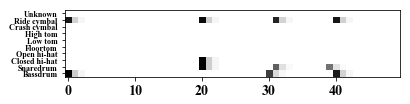

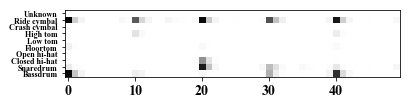

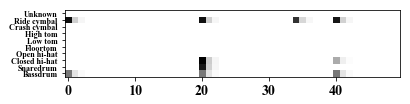

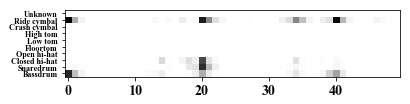

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [24]:
i,j = 240, 30
m = 50
y = vae.predict(x_train[:500])
plot.single(x_train[i,:m])
plot.single(y[i,:m])
plot.single(x_train[j,:m])
plot.single(y[j,:m])

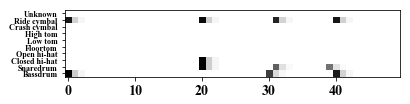

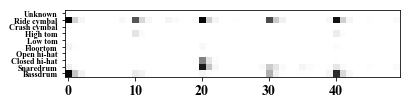

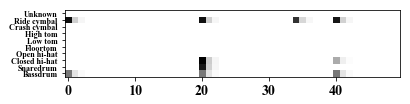

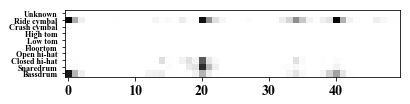

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [25]:
i,j = 0, 10
i,j = 240, 30

m = 50
y = vae.predict(x_train[:500])
plot.single(x_train[i,:m])
plot.single(y[i,:m])
plot.single(x_train[j,:m])
plot.single(y[j,:m])

In [26]:
decoder = generator

## Style transfer

In [27]:
m = 500
x_train_encoded = encoder.predict(x_train[:m], batch_size=batch_size)
x_train_encoded.shape

(500, 10)

In [28]:
# a = list({3:[2],'s':[3,3]}.keys())
# np.random.shuffle(a)
# a

In [29]:
import transformation_extraction

In [52]:
utils.reload(transformation_extraction)
best_dims, importances, transformations, min_transformations = \
    transformation_extraction.between_genres(x_train_encoded, genre_dict, amt1=1000, amt2=1, v=1)


0
Genre A: 06 Soul - Funk/09 Smooth Soul 81BPM
  genre B: 	04 Country/06 Booker 170BPM (len: 7)
 	 i: 0, importance: 0.261000
  genre B: 	04 Country/01 Calvin 148BPM (len: 7)
 	 i: 0, importance: 0.267129

1
Genre A: 06 Soul - Funk/02 Boogaloo 120BPM
  genre B: 	01 Rock'n'Roll/06 Moonglow 140BPM (len: 7)
 	 i: 3, importance: 0.278325
  genre B: 	06 Soul - Funk/07 Ride Swing 95Bpm (len: 7)
 	 i: 1, importance: 0.173748

2
Genre A: 02 Blues/02 Nappy Brown 160BPM
  genre B: 	06 Soul - Funk/10 Syncopated Ride 128BPM (len: 7)
 	 i: 2, importance: 0.295104
  genre B: 	01 Rock'n'Roll/07 Thwag 170BPM (len: 7)
 	 i: 2, importance: 0.287671

3
Genre A: 01 Rock'n'Roll/08 Doowoop 140bpm
  genre B: 	01 Rock'n'Roll/02 Gogo 191BPM (len: 7)
 	 i: 8, importance: 0.170277
  genre B: 	05 Jazz/07 Kooper 234BPM (len: 7)
 	 i: 8, importance: 0.330800

4
Genre A: 05 Jazz/08 Neodop 226BPM 3-4
  genre B: 	06 Soul - Funk/09 Smooth Soul 81BPM (len: 7)
 	 i: 0, importance: 0.212000
  genre B: 	07 Indie/06 Swing 

  genre B: 	01 Rock'n'Roll/07 Thwag 170BPM (len: 7)
 	 i: 7, importance: 0.210381

40
Genre A: 06 Soul - Funk/08 Rim Soul 90BPM
  genre B: 	07 Indie/06 Swing Funk 102BPM (len: 7)
 	 i: 0, importance: 0.258084
  genre B: 	07 Indie/09 Slow Shuffle 80BPM (len: 7)
 	 i: 0, importance: 0.355207

41
Genre A: 02 Blues/01 Booze 92BPM
  genre B: 	05 Jazz/08 Neodop 226BPM 3-4 (len: 7)
 	 i: 9, importance: 0.273622
  genre B: 	03 Traditional Pop/03 King Quiza 102BPM (len: 7)
 	 i: 9, importance: 0.192920

42
Genre A: 02 Blues/08 Sams 127BPM
  genre B: 	05 Jazz/09 West Coast 152BPM Brushes (len: 7)
 	 i: 0, importance: 0.348776
  genre B: 	07 Indie/07 Rock Keeler 133BPM (len: 7)
 	 i: 6, importance: 0.250544

43
Genre A: 07 Indie/06 Swing Funk 102BPM
  genre B: 	04 Country/09 Broonze 122BPM (len: 7)
 	 i: 6, importance: 0.316869
  genre B: 	04 Country/05 Brewer 160BPM (len: 7)
 	 i: 6, importance: 0.187733

44
Genre A: 07 Indie/06 Swing Funk 102BPM
  genre B: 	02 Blues/06 Vidar Vega 70BPM (len: 7)

  genre B: 	04 Country/06 Booker 170BPM (len: 7)
 	 i: 8, importance: 0.237337
  genre B: 	06 Soul - Funk/08 Rim Soul 90BPM (len: 7)
 	 i: 0, importance: 0.298174

80
Genre A: 04 Country/06 Booker 170BPM
  genre B: 	04 Country/05 Brewer 160BPM (len: 7)
 	 i: 0, importance: 0.236359
  genre B: 	03 Traditional Pop/01 Fly High 115BPM (len: 7)
 	 i: 2, importance: 0.340941

81
Genre A: 02 Blues/01 Booze 92BPM
  genre B: 	01 Rock'n'Roll/10 Ottis 172bpm (len: 7)
 	 i: 4, importance: 0.274237
  genre B: 	06 Soul - Funk/07 Ride Swing 95Bpm (len: 7)
 	 i: 5, importance: 0.222068

82
Genre A: 03 Traditional Pop/08 Cecil Cee 101BPM
  genre B: 	05 Jazz/09 West Coast 152BPM Brushes (len: 7)
 	 i: 0, importance: 0.393219
  genre B: 	02 Blues/08 Sams 127BPM (len: 7)
 	 i: 9, importance: 0.204134

83
Genre A: 01 Rock'n'Roll/07 Thwag 170BPM
  genre B: 	07 Indie/02 Rock Tribal 125BPM (len: 7)
 	 i: 6, importance: 0.157472
  genre B: 	01 Rock'n'Roll/03 Lips n Hips 152BPM (len: 7)
 	 i: 6, importance: 0.4

  genre B: 	06 Soul - Funk/02 Boogaloo 120BPM (len: 7)
 	 i: 1, importance: 0.225740
  genre B: 	07 Indie/06 Swing Funk 102BPM (len: 7)
 	 i: 2, importance: 0.240421

119
Genre A: 01 Rock'n'Roll/04 Maybelline 233BPM
  genre B: 	04 Country/02 Marching 94BPM (len: 7)
 	 i: 9, importance: 0.324755
  genre B: 	03 Traditional Pop/09 Distel 155BPM (len: 7)
 	 i: 4, importance: 0.287380

120
Genre A: 05 Jazz/02 Another You 170BPM
  genre B: 	02 Blues/04 Mickeys 212BPM 12-8 (len: 7)
 	 i: 3, importance: 0.231763
  genre B: 	03 Traditional Pop/06 Bopop 130MPM (len: 7)
 	 i: 0, importance: 0.191157

121
Genre A: 04 Country/06 Booker 170BPM
  genre B: 	01 Rock'n'Roll/07 Thwag 170BPM (len: 7)
 	 i: 4, importance: 0.216913
  genre B: 	05 Jazz/02 Another You 170BPM (len: 7)
 	 i: 0, importance: 0.306520

122
Genre A: 06 Soul - Funk/07 Ride Swing 95Bpm
  genre B: 	04 Country/03 Straight 72BPM Brushes (len: 7)
 	 i: 0, importance: 0.326882
  genre B: 	03 Traditional Pop/07 Lester Lee 133BPM (len: 7)
 

  genre B: 	01 Rock'n'Roll/02 Gogo 191BPM (len: 7)
 	 i: 9, importance: 0.414636
  genre B: 	07 Indie/03 Moon 137BPM (len: 7)
 	 i: 9, importance: 0.303246

158
Genre A: 03 Traditional Pop/01 Fly High 115BPM
  genre B: 	05 Jazz/04 Silent Tear 234BPM (len: 7)
 	 i: 0, importance: 0.209248
  genre B: 	06 Soul - Funk/01 Soul Groove 107BPM (len: 7)
 	 i: 0, importance: 0.343711

159
Genre A: 07 Indie/09 Slow Shuffle 80BPM
  genre B: 	05 Jazz/02 Another You 170BPM (len: 7)
 	 i: 0, importance: 0.339591
  genre B: 	01 Rock'n'Roll/01 Dancin Rick 166BPM (len: 7)
 	 i: 6, importance: 0.233880

160
Genre A: 05 Jazz/07 Kooper 234BPM
  genre B: 	03 Traditional Pop/08 Cecil Cee 101BPM (len: 7)
 	 i: 9, importance: 0.302499
  genre B: 	07 Indie/02 Rock Tribal 125BPM (len: 7)
 	 i: 9, importance: 0.225880

161
Genre A: 06 Soul - Funk/06 JB Groove 115BPM
  genre B: 	01 Rock'n'Roll/04 Maybelline 233BPM (len: 7)
 	 i: 4, importance: 0.262455
  genre B: 	02 Blues/08 Sams 127BPM (len: 7)
 	 i: 9, importan

  genre B: 	06 Soul - Funk/02 Boogaloo 120BPM (len: 7)
 	 i: 9, importance: 0.235318
  genre B: 	02 Blues/08 Sams 127BPM (len: 7)
 	 i: 9, importance: 0.306623

197
Genre A: 04 Country/10 Rough Rider 183BPM
  genre B: 	07 Indie/04 Titanic 97BPM (len: 7)
 	 i: 2, importance: 0.190130
  genre B: 	05 Jazz/10 Scalis 190BPM 3-4 (len: 7)
 	 i: 6, importance: 0.307165

198
Genre A: 04 Country/01 Calvin 148BPM
  genre B: 	06 Soul - Funk/08 Rim Soul 90BPM (len: 7)
 	 i: 0, importance: 0.313730
  genre B: 	06 Soul - Funk/09 Smooth Soul 81BPM (len: 7)
 	 i: 0, importance: 0.282380

199
Genre A: 07 Indie/08 Bouncer 162BPM
  genre B: 	05 Jazz/09 West Coast 152BPM Brushes (len: 7)
 	 i: 0, importance: 0.373834
  genre B: 	07 Indie/03 Moon 137BPM (len: 7)
 	 i: 8, importance: 0.183673

200
Genre A: 03 Traditional Pop/05 Your Eyes 80BPM
  genre B: 	06 Soul - Funk/09 Smooth Soul 81BPM (len: 7)
 	 i: 0, importance: 0.307311
  genre B: 	03 Traditional Pop/08 Cecil Cee 101BPM (len: 7)
 	 i: 9, importance:

  genre B: 	01 Rock'n'Roll/03 Lips n Hips 152BPM (len: 7)
 	 i: 6, importance: 0.322996

235
Genre A: 02 Blues/02 Nappy Brown 160BPM
  genre B: 	07 Indie/03 Moon 137BPM (len: 7)
 	 i: 6, importance: 0.304651
  genre B: 	04 Country/10 Rough Rider 183BPM (len: 7)
 	 i: 5, importance: 0.312192

236
Genre A: 03 Traditional Pop/02 Frankies Girl 116BPM
  genre B: 	02 Blues/08 Sams 127BPM (len: 7)
 	 i: 6, importance: 0.232363
  genre B: 	04 Country/05 Brewer 160BPM (len: 7)
 	 i: 6, importance: 0.172955

237
Genre A: 07 Indie/11 Disco Dancer 135BPM
  genre B: 	02 Blues/01 Booze 92BPM (len: 7)
 	 i: 9, importance: 0.307503
  genre B: 	06 Soul - Funk/01 Soul Groove 107BPM (len: 7)
 	 i: 0, importance: 0.292000

238
Genre A: 03 Traditional Pop/05 Your Eyes 80BPM
  genre B: 	07 Indie/03 Moon 137BPM (len: 7)
 	 i: 9, importance: 0.212793
  genre B: 	04 Country/08 Eddie Ed 111BPM (len: 7)
 	 i: 2, importance: 0.289547

239
Genre A: 02 Blues/03 Noton Bull 192BPM 12-8 Brushes
  genre B: 	07 Indie/06

  genre B: 	02 Blues/10 Bogeart 122BPM (len: 7)
 	 i: 9, importance: 0.329709
  genre B: 	07 Indie/09 Slow Shuffle 80BPM (len: 7)
 	 i: 4, importance: 0.180765

274
Genre A: 01 Rock'n'Roll/07 Thwag 170BPM
  genre B: 	03 Traditional Pop/01 Fly High 115BPM (len: 7)
 	 i: 2, importance: 0.257509
  genre B: 	03 Traditional Pop/07 Lester Lee 133BPM (len: 7)
 	 i: 6, importance: 0.267371

275
Genre A: 06 Soul - Funk/05 Hip Hop 95BPM
  genre B: 	06 Soul - Funk/09 Smooth Soul 81BPM (len: 7)
 	 i: 6, importance: 0.214140
  genre B: 	04 Country/02 Marching 94BPM (len: 7)
 	 i: 0, importance: 0.378419

276
Genre A: 02 Blues/02 Nappy Brown 160BPM
  genre B: 	01 Rock'n'Roll/09 Diddeley 185bpm (len: 7)
 	 i: 6, importance: 0.281183
  genre B: 	07 Indie/09 Slow Shuffle 80BPM (len: 7)
 	 i: 5, importance: 0.214339

277
Genre A: 03 Traditional Pop/03 King Quiza 102BPM
  genre B: 	03 Traditional Pop/01 Fly High 115BPM (len: 7)
 	 i: 1, importance: 0.211169
  genre B: 	07 Indie/11 Disco Dancer 135BPM (le

  genre B: 	01 Rock'n'Roll/05 Straight Line 136BPM (len: 7)
 	 i: 8, importance: 0.170813
  genre B: 	01 Rock'n'Roll/01 Dancin Rick 166BPM (len: 7)
 	 i: 6, importance: 0.214421

313
Genre A: 07 Indie/05 Halftime 71BPM
  genre B: 	02 Blues/01 Booze 92BPM (len: 7)
 	 i: 5, importance: 0.236643
  genre B: 	04 Country/04 Snarey 208BPM 3-4 (len: 7)
 	 i: 5, importance: 0.273898

314
Genre A: 07 Indie/07 Rock Keeler 133BPM
  genre B: 	01 Rock'n'Roll/09 Diddeley 185bpm (len: 7)
 	 i: 2, importance: 0.212533
  genre B: 	04 Country/07 Trainy 100BPM (len: 7)
 	 i: 6, importance: 0.203899

315
Genre A: 07 Indie/10 Chilled 120BPM
  genre B: 	07 Indie/09 Slow Shuffle 80BPM (len: 7)
 	 i: 9, importance: 0.202501
  genre B: 	03 Traditional Pop/09 Distel 155BPM (len: 7)
 	 i: 6, importance: 0.170143

316
Genre A: 06 Soul - Funk/04 GoGo Soul 100BPM
  genre B: 	03 Traditional Pop/07 Lester Lee 133BPM (len: 7)
 	 i: 0, importance: 0.278763
  genre B: 	07 Indie/02 Rock Tribal 125BPM (len: 7)
 	 i: 9, imp

  genre B: 	05 Jazz/04 Silent Tear 234BPM (len: 7)
 	 i: 0, importance: 0.169809
  genre B: 	05 Jazz/07 Kooper 234BPM (len: 7)
 	 i: 0, importance: 0.140673

352
Genre A: 02 Blues/03 Noton Bull 192BPM 12-8 Brushes
  genre B: 	01 Rock'n'Roll/06 Moonglow 140BPM (len: 7)
 	 i: 2, importance: 0.319647
  genre B: 	06 Soul - Funk/02 Boogaloo 120BPM (len: 7)
 	 i: 3, importance: 0.266317

353
Genre A: 01 Rock'n'Roll/03 Lips n Hips 152BPM
  genre B: 	06 Soul - Funk/02 Boogaloo 120BPM (len: 7)
 	 i: 0, importance: 0.199026
  genre B: 	02 Blues/05 Cadillac 128BPM (len: 7)
 	 i: 6, importance: 0.225203

354
Genre A: 04 Country/07 Trainy 100BPM
  genre B: 	04 Country/06 Booker 170BPM (len: 7)
 	 i: 5, importance: 0.229180
  genre B: 	01 Rock'n'Roll/04 Maybelline 233BPM (len: 7)
 	 i: 9, importance: 0.300749

355
Genre A: 06 Soul - Funk/06 JB Groove 115BPM
  genre B: 	03 Traditional Pop/09 Distel 155BPM (len: 7)
 	 i: 9, importance: 0.177209
  genre B: 	02 Blues/06 Vidar Vega 70BPM (len: 7)
 	 i: 9

  genre B: 	05 Jazz/04 Silent Tear 234BPM (len: 7)
 	 i: 0, importance: 0.251385
  genre B: 	02 Blues/04 Mickeys 212BPM 12-8 (len: 7)
 	 i: 6, importance: 0.257623

391
Genre A: 06 Soul - Funk/07 Ride Swing 95Bpm
  genre B: 	01 Rock'n'Roll/09 Diddeley 185bpm (len: 7)
 	 i: 2, importance: 0.287422
  genre B: 	07 Indie/01 Rock Shuffle 130BPM (len: 7)
 	 i: 7, importance: 0.254230

392
Genre A: 02 Blues/06 Vidar Vega 70BPM
  genre B: 	07 Indie/05 Halftime 71BPM (len: 7)
 	 i: 0, importance: 0.177072
  genre B: 	07 Indie/08 Bouncer 162BPM (len: 7)
 	 i: 9, importance: 0.305974

393
Genre A: 02 Blues/07 Straight 88BPM
  genre B: 	02 Blues/02 Nappy Brown 160BPM (len: 7)
 	 i: 6, importance: 0.294711
  genre B: 	04 Country/10 Rough Rider 183BPM (len: 7)
 	 i: 5, importance: 0.312699

394
Genre A: 07 Indie/03 Moon 137BPM
  genre B: 	02 Blues/08 Sams 127BPM (len: 7)
 	 i: 9, importance: 0.340144
  genre B: 	06 Soul - Funk/08 Rim Soul 90BPM (len: 7)
 	 i: 0, importance: 0.264553

395
Genre A: 04

  genre B: 	01 Rock'n'Roll/10 Ottis 172bpm (len: 7)
 	 i: 0, importance: 0.299611

429
Genre A: 07 Indie/04 Titanic 97BPM
  genre B: 	07 Indie/11 Disco Dancer 135BPM (len: 7)
 	 i: 2, importance: 0.184485
  genre B: 	03 Traditional Pop/04 Love 155BPM (len: 7)
 	 i: 5, importance: 0.263474

430
Genre A: 01 Rock'n'Roll/01 Dancin Rick 166BPM
  genre B: 	07 Indie/10 Chilled 120BPM (len: 7)
 	 i: 6, importance: 0.222616
  genre B: 	05 Jazz/03 Cool 137BPM Brushes (len: 7)
 	 i: 0, importance: 0.218508

431
Genre A: 05 Jazz/07 Kooper 234BPM
  genre B: 	02 Blues/04 Mickeys 212BPM 12-8 (len: 7)
 	 i: 8, importance: 0.286038
  genre B: 	07 Indie/08 Bouncer 162BPM (len: 7)
 	 i: 8, importance: 0.294881

432
Genre A: 01 Rock'n'Roll/05 Straight Line 136BPM
  genre B: 	06 Soul - Funk/01 Soul Groove 107BPM (len: 7)
 	 i: 0, importance: 0.366885
  genre B: 	04 Country/03 Straight 72BPM Brushes (len: 7)
 	 i: 0, importance: 0.368023

433
Genre A: 06 Soul - Funk/08 Rim Soul 90BPM
  genre B: 	03 Traditio

  genre B: 	07 Indie/08 Bouncer 162BPM (len: 7)
 	 i: 8, importance: 0.196073
  genre B: 	04 Country/09 Broonze 122BPM (len: 7)
 	 i: 9, importance: 0.239263

468
Genre A: 02 Blues/04 Mickeys 212BPM 12-8
  genre B: 	06 Soul - Funk/07 Ride Swing 95Bpm (len: 7)
 	 i: 2, importance: 0.279313
  genre B: 	02 Blues/05 Cadillac 128BPM (len: 7)
 	 i: 5, importance: 0.308933

469
Genre A: 04 Country/10 Rough Rider 183BPM
  genre B: 	06 Soul - Funk/09 Smooth Soul 81BPM (len: 7)
 	 i: 0, importance: 0.269892
  genre B: 	06 Soul - Funk/01 Soul Groove 107BPM (len: 7)
 	 i: 0, importance: 0.351581

470
Genre A: 04 Country/10 Rough Rider 183BPM
  genre B: 	06 Soul - Funk/09 Smooth Soul 81BPM (len: 7)
 	 i: 0, importance: 0.269892
  genre B: 	02 Blues/06 Vidar Vega 70BPM (len: 7)
 	 i: 7, importance: 0.269580

471
Genre A: 05 Jazz/03 Cool 137BPM Brushes
  genre B: 	05 Jazz/04 Silent Tear 234BPM (len: 7)
 	 i: 5, importance: 0.243162
  genre B: 	06 Soul - Funk/01 Soul Groove 107BPM (len: 7)
 	 i: 0, im

  genre B: 	04 Country/08 Eddie Ed 111BPM (len: 7)
 	 i: 2, importance: 0.242965
  genre B: 	03 Traditional Pop/03 King Quiza 102BPM (len: 7)
 	 i: 1, importance: 0.284187

507
Genre A: 03 Traditional Pop/09 Distel 155BPM
  genre B: 	06 Soul - Funk/04 GoGo Soul 100BPM (len: 7)
 	 i: 0, importance: 0.311922
  genre B: 	05 Jazz/01 Amel 85BPM Brushes (len: 7)
 	 i: 9, importance: 0.198898

508
Genre A: 01 Rock'n'Roll/02 Gogo 191BPM
  genre B: 	07 Indie/05 Halftime 71BPM (len: 7)
 	 i: 9, importance: 0.391420
  genre B: 	06 Soul - Funk/10 Syncopated Ride 128BPM (len: 7)
 	 i: 3, importance: 0.213193

509
Genre A: 06 Soul - Funk/02 Boogaloo 120BPM
  genre B: 	04 Country/01 Calvin 148BPM (len: 7)
 	 i: 0, importance: 0.335776
  genre B: 	02 Blues/03 Noton Bull 192BPM 12-8 Brushes (len: 7)
 	 i: 3, importance: 0.248706

510
Genre A: 02 Blues/05 Cadillac 128BPM
  genre B: 	03 Traditional Pop/04 Love 155BPM (len: 7)
 	 i: 5, importance: 0.274298
  genre B: 	01 Rock'n'Roll/08 Doowoop 140bpm (len

  genre B: 	07 Indie/06 Swing Funk 102BPM (len: 7)
 	 i: 0, importance: 0.235380
  genre B: 	07 Indie/10 Chilled 120BPM (len: 7)
 	 i: 0, importance: 0.188478

546
Genre A: 05 Jazz/02 Another You 170BPM
  genre B: 	07 Indie/11 Disco Dancer 135BPM (len: 7)
 	 i: 0, importance: 0.275861
  genre B: 	02 Blues/05 Cadillac 128BPM (len: 7)
 	 i: 0, importance: 0.196000

547
Genre A: 05 Jazz/07 Kooper 234BPM
  genre B: 	03 Traditional Pop/10 Frewild 152BPM (len: 7)
 	 i: 8, importance: 0.275210
  genre B: 	05 Jazz/04 Silent Tear 234BPM (len: 7)
 	 i: 9, importance: 0.278315

548
Genre A: 06 Soul - Funk/08 Rim Soul 90BPM
  genre B: 	05 Jazz/08 Neodop 226BPM 3-4 (len: 7)
 	 i: 0, importance: 0.184000
  genre B: 	05 Jazz/03 Cool 137BPM Brushes (len: 7)
 	 i: 0, importance: 0.373169

549
Genre A: 04 Country/02 Marching 94BPM
  genre B: 	01 Rock'n'Roll/01 Dancin Rick 166BPM (len: 7)
 	 i: 9, importance: 0.255206
  genre B: 	04 Country/05 Brewer 160BPM (len: 7)
 	 i: 9, importance: 0.271931

550
Gen

  genre B: 	07 Indie/08 Bouncer 162BPM (len: 7)
 	 i: 1, importance: 0.283752
  genre B: 	01 Rock'n'Roll/08 Doowoop 140bpm (len: 7)
 	 i: 2, importance: 0.180262

585
Genre A: 06 Soul - Funk/10 Syncopated Ride 128BPM
  genre B: 	04 Country/03 Straight 72BPM Brushes (len: 7)
 	 i: 0, importance: 0.372640
  genre B: 	05 Jazz/01 Amel 85BPM Brushes (len: 7)
 	 i: 3, importance: 0.288663

586
Genre A: 05 Jazz/10 Scalis 190BPM 3-4
  genre B: 	04 Country/08 Eddie Ed 111BPM (len: 7)
 	 i: 6, importance: 0.240718
  genre B: 	04 Country/01 Calvin 148BPM (len: 7)
 	 i: 0, importance: 0.277203

587
Genre A: 05 Jazz/08 Neodop 226BPM 3-4
  genre B: 	01 Rock'n'Roll/10 Ottis 172bpm (len: 7)
 	 i: 9, importance: 0.276700
  genre B: 	01 Rock'n'Roll/05 Straight Line 136BPM (len: 7)
 	 i: 9, importance: 0.231739

588
Genre A: 01 Rock'n'Roll/06 Moonglow 140BPM
  genre B: 	07 Indie/11 Disco Dancer 135BPM (len: 7)
 	 i: 3, importance: 0.233825
  genre B: 	02 Blues/01 Booze 92BPM (len: 7)
 	 i: 9, importance:

  genre B: 	01 Rock'n'Roll/04 Maybelline 233BPM (len: 7)
 	 i: 0, importance: 0.351591

623
Genre A: 06 Soul - Funk/01 Soul Groove 107BPM
  genre B: 	03 Traditional Pop/09 Distel 155BPM (len: 7)
 	 i: 0, importance: 0.394050
  genre B: 	02 Blues/08 Sams 127BPM (len: 7)
 	 i: 0, importance: 0.329557

624
Genre A: 07 Indie/05 Halftime 71BPM
  genre B: 	02 Blues/07 Straight 88BPM (len: 7)
 	 i: 5, importance: 0.283980
  genre B: 	01 Rock'n'Roll/03 Lips n Hips 152BPM (len: 7)
 	 i: 9, importance: 0.251706

625
Genre A: 01 Rock'n'Roll/04 Maybelline 233BPM
  genre B: 	03 Traditional Pop/04 Love 155BPM (len: 7)
 	 i: 8, importance: 0.218641
  genre B: 	04 Country/04 Snarey 208BPM 3-4 (len: 7)
 	 i: 6, importance: 0.235714

626
Genre A: 03 Traditional Pop/08 Cecil Cee 101BPM
  genre B: 	02 Blues/01 Booze 92BPM (len: 7)
 	 i: 7, importance: 0.273001
  genre B: 	06 Soul - Funk/06 JB Groove 115BPM (len: 7)
 	 i: 9, importance: 0.417567

627
Genre A: 02 Blues/02 Nappy Brown 160BPM
  genre B: 	07 I

  genre B: 	07 Indie/11 Disco Dancer 135BPM (len: 7)
 	 i: 6, importance: 0.181165
  genre B: 	04 Country/01 Calvin 148BPM (len: 7)
 	 i: 0, importance: 0.286112

662
Genre A: 02 Blues/03 Noton Bull 192BPM 12-8 Brushes
  genre B: 	02 Blues/04 Mickeys 212BPM 12-8 (len: 7)
 	 i: 2, importance: 0.318389
  genre B: 	06 Soul - Funk/06 JB Groove 115BPM (len: 7)
 	 i: 6, importance: 0.268348

663
Genre A: 04 Country/09 Broonze 122BPM
  genre B: 	01 Rock'n'Roll/09 Diddeley 185bpm (len: 7)
 	 i: 4, importance: 0.294106
  genre B: 	01 Rock'n'Roll/02 Gogo 191BPM (len: 7)
 	 i: 9, importance: 0.353640

664
Genre A: 04 Country/08 Eddie Ed 111BPM
  genre B: 	05 Jazz/04 Silent Tear 234BPM (len: 7)
 	 i: 8, importance: 0.229789
  genre B: 	02 Blues/04 Mickeys 212BPM 12-8 (len: 7)
 	 i: 0, importance: 0.231187

665
Genre A: 07 Indie/10 Chilled 120BPM
  genre B: 	02 Blues/07 Straight 88BPM (len: 7)
 	 i: 0, importance: 0.156672
  genre B: 	03 Traditional Pop/05 Your Eyes 80BPM (len: 7)
 	 i: 6, importan

  genre B: 	04 Country/08 Eddie Ed 111BPM (len: 7)
 	 i: 8, importance: 0.224142
  genre B: 	06 Soul - Funk/01 Soul Groove 107BPM (len: 7)
 	 i: 0, importance: 0.316108

701
Genre A: 01 Rock'n'Roll/10 Ottis 172bpm
  genre B: 	03 Traditional Pop/05 Your Eyes 80BPM (len: 7)
 	 i: 4, importance: 0.127117
  genre B: 	07 Indie/09 Slow Shuffle 80BPM (len: 7)
 	 i: 9, importance: 0.218925

702
Genre A: 06 Soul - Funk/06 JB Groove 115BPM
  genre B: 	01 Rock'n'Roll/09 Diddeley 185bpm (len: 7)
 	 i: 1, importance: 0.309601
  genre B: 	02 Blues/03 Noton Bull 192BPM 12-8 Brushes (len: 7)
 	 i: 6, importance: 0.277945

703
Genre A: 04 Country/10 Rough Rider 183BPM
  genre B: 	06 Soul - Funk/08 Rim Soul 90BPM (len: 7)
 	 i: 0, importance: 0.306426
  genre B: 	04 Country/09 Broonze 122BPM (len: 7)
 	 i: 7, importance: 0.244507

704
Genre A: 01 Rock'n'Roll/09 Diddeley 185bpm
  genre B: 	04 Country/05 Brewer 160BPM (len: 7)
 	 i: 5, importance: 0.178695
  genre B: 	03 Traditional Pop/09 Distel 155BPM (

  genre B: 	04 Country/03 Straight 72BPM Brushes (len: 7)
 	 i: 0, importance: 0.283687
  genre B: 	05 Jazz/10 Scalis 190BPM 3-4 (len: 7)
 	 i: 0, importance: 0.256143

740
Genre A: 07 Indie/11 Disco Dancer 135BPM
  genre B: 	06 Soul - Funk/03 Cadence Soul 105BPM (len: 7)
 	 i: 9, importance: 0.203319
  genre B: 	06 Soul - Funk/04 GoGo Soul 100BPM (len: 7)
 	 i: 0, importance: 0.213146

741
Genre A: 04 Country/03 Straight 72BPM Brushes
  genre B: 	05 Jazz/05 TNT 116BPM (len: 7)
 	 i: 0, importance: 0.382185
  genre B: 	01 Rock'n'Roll/03 Lips n Hips 152BPM (len: 7)
 	 i: 0, importance: 0.361893

742
Genre A: 07 Indie/01 Rock Shuffle 130BPM
  genre B: 	05 Jazz/02 Another You 170BPM (len: 7)
 	 i: 0, importance: 0.324862
  genre B: 	02 Blues/08 Sams 127BPM (len: 7)
 	 i: 3, importance: 0.241756

743
Genre A: 05 Jazz/04 Silent Tear 234BPM
  genre B: 	05 Jazz/06 Nucleus 172BPM Brushes (len: 7)
 	 i: 0, importance: 0.327427
  genre B: 	07 Indie/01 Rock Shuffle 130BPM (len: 7)
 	 i: 3, import

  genre B: 	03 Traditional Pop/10 Frewild 152BPM (len: 7)
 	 i: 9, importance: 0.230104
  genre B: 	07 Indie/10 Chilled 120BPM (len: 7)
 	 i: 7, importance: 0.190527

779
Genre A: 02 Blues/10 Bogeart 122BPM
  genre B: 	05 Jazz/02 Another You 170BPM (len: 7)
 	 i: 0, importance: 0.274390
  genre B: 	05 Jazz/05 TNT 116BPM (len: 7)
 	 i: 5, importance: 0.208765

780
Genre A: 02 Blues/09 Leroyes 130BPM
  genre B: 	03 Traditional Pop/04 Love 155BPM (len: 7)
 	 i: 8, importance: 0.307554
  genre B: 	03 Traditional Pop/10 Frewild 152BPM (len: 7)
 	 i: 7, importance: 0.253975

781
Genre A: 05 Jazz/05 TNT 116BPM
  genre B: 	01 Rock'n'Roll/06 Moonglow 140BPM (len: 7)
 	 i: 2, importance: 0.199199
  genre B: 	06 Soul - Funk/01 Soul Groove 107BPM (len: 7)
 	 i: 0, importance: 0.387079

782
Genre A: 05 Jazz/06 Nucleus 172BPM Brushes
  genre B: 	05 Jazz/10 Scalis 190BPM 3-4 (len: 7)
 	 i: 6, importance: 0.321206
  genre B: 	07 Indie/09 Slow Shuffle 80BPM (len: 7)
 	 i: 0, importance: 0.367648

783
G

  genre B: 	02 Blues/08 Sams 127BPM (len: 7)
 	 i: 0, importance: 0.219527
  genre B: 	01 Rock'n'Roll/09 Diddeley 185bpm (len: 7)
 	 i: 1, importance: 0.312599

818
Genre A: 06 Soul - Funk/09 Smooth Soul 81BPM
  genre B: 	01 Rock'n'Roll/03 Lips n Hips 152BPM (len: 7)
 	 i: 0, importance: 0.335350
  genre B: 	01 Rock'n'Roll/08 Doowoop 140bpm (len: 7)
 	 i: 6, importance: 0.312601

819
Genre A: 01 Rock'n'Roll/05 Straight Line 136BPM
  genre B: 	07 Indie/08 Bouncer 162BPM (len: 7)
 	 i: 8, importance: 0.222071
  genre B: 	01 Rock'n'Roll/01 Dancin Rick 166BPM (len: 7)
 	 i: 6, importance: 0.228960

820
Genre A: 06 Soul - Funk/09 Smooth Soul 81BPM
  genre B: 	01 Rock'n'Roll/03 Lips n Hips 152BPM (len: 7)
 	 i: 0, importance: 0.335350
  genre B: 	05 Jazz/05 TNT 116BPM (len: 7)
 	 i: 6, importance: 0.330651

821
Genre A: 03 Traditional Pop/09 Distel 155BPM
  genre B: 	07 Indie/10 Chilled 120BPM (len: 7)
 	 i: 6, importance: 0.166812
  genre B: 	04 Country/07 Trainy 100BPM (len: 7)
 	 i: 6, im

  genre B: 	05 Jazz/07 Kooper 234BPM (len: 7)
 	 i: 0, importance: 0.288960
  genre B: 	01 Rock'n'Roll/09 Diddeley 185bpm (len: 7)
 	 i: 0, importance: 0.217000

857
Genre A: 02 Blues/09 Leroyes 130BPM
  genre B: 	01 Rock'n'Roll/02 Gogo 191BPM (len: 7)
 	 i: 9, importance: 0.277766
  genre B: 	05 Jazz/07 Kooper 234BPM (len: 7)
 	 i: 8, importance: 0.319487

858
Genre A: 06 Soul - Funk/05 Hip Hop 95BPM
  genre B: 	05 Jazz/09 West Coast 152BPM Brushes (len: 7)
 	 i: 0, importance: 0.339787
  genre B: 	06 Soul - Funk/08 Rim Soul 90BPM (len: 7)
 	 i: 5, importance: 0.230355

859
Genre A: 04 Country/03 Straight 72BPM Brushes
  genre B: 	05 Jazz/07 Kooper 234BPM (len: 7)
 	 i: 0, importance: 0.396703
  genre B: 	02 Blues/06 Vidar Vega 70BPM (len: 7)
 	 i: 0, importance: 0.319612

860
Genre A: 02 Blues/03 Noton Bull 192BPM 12-8 Brushes
  genre B: 	01 Rock'n'Roll/02 Gogo 191BPM (len: 7)
 	 i: 6, importance: 0.310588
  genre B: 	05 Jazz/09 West Coast 152BPM Brushes (len: 7)
 	 i: 3, importance:

  genre B: 	05 Jazz/10 Scalis 190BPM 3-4 (len: 7)
 	 i: 0, importance: 0.302218
  genre B: 	04 Country/02 Marching 94BPM (len: 7)
 	 i: 9, importance: 0.204877

896
Genre A: 07 Indie/05 Halftime 71BPM
  genre B: 	01 Rock'n'Roll/09 Diddeley 185bpm (len: 7)
 	 i: 9, importance: 0.184295
  genre B: 	05 Jazz/09 West Coast 152BPM Brushes (len: 7)
 	 i: 0, importance: 0.383211

897
Genre A: 06 Soul - Funk/08 Rim Soul 90BPM
  genre B: 	06 Soul - Funk/06 JB Groove 115BPM (len: 7)
 	 i: 0, importance: 0.267458
  genre B: 	06 Soul - Funk/01 Soul Groove 107BPM (len: 7)
 	 i: 5, importance: 0.201051

898
Genre A: 04 Country/08 Eddie Ed 111BPM
  genre B: 	06 Soul - Funk/04 GoGo Soul 100BPM (len: 7)
 	 i: 0, importance: 0.253681
  genre B: 	06 Soul - Funk/05 Hip Hop 95BPM (len: 7)
 	 i: 0, importance: 0.319382

899
Genre A: 07 Indie/03 Moon 137BPM
  genre B: 	06 Soul - Funk/03 Cadence Soul 105BPM (len: 7)
 	 i: 9, importance: 0.333633
  genre B: 	02 Blues/02 Nappy Brown 160BPM (len: 7)
 	 i: 6, impo

  genre B: 	06 Soul - Funk/05 Hip Hop 95BPM (len: 7)
 	 i: 0, importance: 0.279063

934
Genre A: 02 Blues/09 Leroyes 130BPM
  genre B: 	03 Traditional Pop/10 Frewild 152BPM (len: 7)
 	 i: 7, importance: 0.253975
  genre B: 	04 Country/06 Booker 170BPM (len: 7)
 	 i: 1, importance: 0.198712

935
Genre A: 07 Indie/11 Disco Dancer 135BPM
  genre B: 	01 Rock'n'Roll/07 Thwag 170BPM (len: 7)
 	 i: 6, importance: 0.224548
  genre B: 	04 Country/05 Brewer 160BPM (len: 7)
 	 i: 3, importance: 0.175754

936
Genre A: 02 Blues/04 Mickeys 212BPM 12-8
  genre B: 	02 Blues/06 Vidar Vega 70BPM (len: 7)
 	 i: 9, importance: 0.413941
  genre B: 	01 Rock'n'Roll/06 Moonglow 140BPM (len: 7)
 	 i: 7, importance: 0.181937

937
Genre A: 04 Country/05 Brewer 160BPM
  genre B: 	06 Soul - Funk/01 Soul Groove 107BPM (len: 7)
 	 i: 0, importance: 0.374651
  genre B: 	01 Rock'n'Roll/02 Gogo 191BPM (len: 7)
 	 i: 2, importance: 0.232349

938
Genre A: 05 Jazz/09 West Coast 152BPM Brushes
  genre B: 	05 Jazz/08 Neodop

  genre B: 	07 Indie/06 Swing Funk 102BPM (len: 7)
 	 i: 0, importance: 0.258084

973
Genre A: 04 Country/10 Rough Rider 183BPM
  genre B: 	04 Country/03 Straight 72BPM Brushes (len: 7)
 	 i: 8, importance: 0.190001
  genre B: 	05 Jazz/08 Neodop 226BPM 3-4 (len: 7)
 	 i: 4, importance: 0.268031

974
Genre A: 03 Traditional Pop/06 Bopop 130MPM
  genre B: 	04 Country/05 Brewer 160BPM (len: 7)
 	 i: 9, importance: 0.215139
  genre B: 	04 Country/09 Broonze 122BPM (len: 7)
 	 i: 7, importance: 0.197482

975
Genre A: 04 Country/04 Snarey 208BPM 3-4
  genre B: 	01 Rock'n'Roll/04 Maybelline 233BPM (len: 7)
 	 i: 6, importance: 0.223627
  genre B: 	01 Rock'n'Roll/10 Ottis 172bpm (len: 7)
 	 i: 6, importance: 0.161465

976
Genre A: 01 Rock'n'Roll/05 Straight Line 136BPM
  genre B: 	01 Rock'n'Roll/06 Moonglow 140BPM (len: 7)
 	 i: 6, importance: 0.263578
  genre B: 	07 Indie/08 Bouncer 162BPM (len: 7)
 	 i: 8, importance: 0.222071

977
Genre A: 04 Country/06 Booker 170BPM
  genre B: 	04 Country/

In [53]:
print('avg importance: %f' % np.mean(importances))

avg importance: 0.264393


In [64]:
# amt of tranformations (56)
print(sum([len(list(sub_transformations.keys())) for sub_tranformations in transformations.values()]))
len(list(transformations.keys()))

NameError: name 'sub_transformations' is not defined

In [55]:
for genre_A, d in min_transformations.items():
    print('\nGenre `%s` to: \n dim:\tgenre:' % genre_A)
    for genre_B, vector in d.items():
        print(' %i \t%s' % (np.argmax(vector), genre_B))  


Genre `06 Soul - Funk/09 Smooth Soul 81BPM` to: 
 dim:	genre:
 0 	01 Rock'n'Roll/09 Diddeley 185bpm
 0 	04 Country/01 Calvin 148BPM

Genre `06 Soul - Funk/02 Boogaloo 120BPM` to: 
 dim:	genre:
 1 	06 Soul - Funk/01 Soul Groove 107BPM
 0 	04 Country/03 Straight 72BPM Brushes

Genre `02 Blues/02 Nappy Brown 160BPM` to: 
 dim:	genre:
 0 	03 Traditional Pop/03 King Quiza 102BPM
 0 	07 Indie/10 Chilled 120BPM

Genre `01 Rock'n'Roll/08 Doowoop 140bpm` to: 
 dim:	genre:
 1 	06 Soul - Funk/09 Smooth Soul 81BPM
 0 	04 Country/05 Brewer 160BPM

Genre `05 Jazz/08 Neodop 226BPM 3-4` to: 
 dim:	genre:
 4 	04 Country/10 Rough Rider 183BPM
 9 	03 Traditional Pop/02 Frankies Girl 116BPM

Genre `07 Indie/04 Titanic 97BPM` to: 
 dim:	genre:
 5 	07 Indie/05 Halftime 71BPM
 0 	02 Blues/03 Noton Bull 192BPM 12-8 Brushes

Genre `02 Blues/10 Bogeart 122BPM` to: 
 dim:	genre:
 0 	04 Country/01 Calvin 148BPM
 9 	03 Traditional Pop/01 Fly High 115BPM

Genre `05 Jazz/05 TNT 116BPM` to: 
 dim:	genre:
 0 	03 Trad

(array([631., 134., 177.,  50., 112., 148., 247.,  77.,  91., 333.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

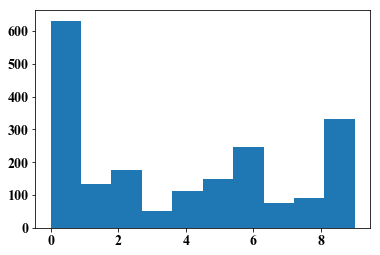

In [56]:
plt.hist(best_dims)

In [58]:
# TODO save as python object (or json)

In [59]:
# def save_transformation_dicts(transformations={}, dn='', v=0):
#     for genre_A, sub_dict in transformations.items():
#         # sub_dict :: {'genre_B_2/genre_B_2': vector}
#         a1, a2 = genre_A.split('/')
#         if a1 not in os.listdir(dn): os.mkdir(dn + a1)
#         if v:
#             print(genre_A)
#             print(sub_dict.keys())
#         io.save_dict(dn + a1, a2, sub_dict)

fn = config.plots_dir + 'transformations-best_dims.pkl'
io.save(best_dims, fn)

fn = config.plots_dir + 'transformations.pkl'
io.save(transformations, fn)

fn = config.plots_dir + 'min_transformations.pkl'
io.save(min_transformations, fn)

'../results/min_transformations.pkl'

In [60]:
t_ = io.load(fn)

In [61]:
# transformations = io.read_categorical_dict_dir(config.plots_dir + 'transformations/')
# min_transformations = io.read_categorical_dict_dir(config.plots_dir + 'min_transformations/') 

In [62]:
list(transformations.keys())[:3]

['06 Soul - Funk/09 Smooth Soul 81BPM',
 '06 Soul - Funk/02 Boogaloo 120BPM',
 '02 Blues/02 Nappy Brown 160BPM']

In [63]:
len(transformations.keys())

71